<div style="background-color: #ccffcc; padding: 10px;">
    <h1> Tutorial 5 </h1> 
    <h2> Auto Encoders </h2>
</div>      


# Overview

This Jupyter notebook will walk you through building a simple AutoEcoder model and training it on the [MNIST dataset](https://en.wikipedia.org/wiki/MNIST_database) using [TensorFlow](https://www.tensorflow.org/). TensorFlow is a very powerful library written in Python and C++ that facilitates the building and training of neural networks.

This tutorial is was adapted from Clare Bartholemew Presentation. Following Vikram Tiwaris's Kaggel [example] (https://www.kaggle.com/code/vikramtiwari/autoencoders-using-tf-keras-mnist/) based on [a keras blog](https://blog.keras.io/building-autoencoders-in-keras.html)



## The very basics

If you know nothing about neural networks there is a [toy neural network python code example](https://github.com/cemac/LIFD_ENV_ML_NOTEBOOKS/tree/main/ToyNeuralNetwork) included in the [LIFD ENV ML Notebooks Repository]( https://github.com/cemac/LIFD_ENV_ML_NOTEBOOKS). Creating a 2 layer neural network to illustrate the fundamentals of how Neural Networks work and the equivalent code using the python machine learning library [keras](https://keras.io/). 


## Recommended reading 


* [All you need to know on Neural networks](https://towardsdatascience.com/nns-aynk-c34efe37f15a) 
* [Introduction to Neural Networks](https://victorzhou.com/blog/intro-to-neural-networks/)
* [Auto Encoders](https://towardsdatascience.com/applied-deep-learning-part-3-autoencoders-1c083af4d798)


## Additional Reading For Earth Science Applications

At the end of this notebook, we'll take a brief look at some non-interactive earth science examples:

* [Reconstructing missing SST data using AutoEncoders](https://gmd.copernicus.org/articles/13/1609/2020/) [(code hosted here)](https://github.com/gher-uliege/DINCAE)
* [Using an AutoEncoder to mimic a GCM](https://brohan.org/ML_GCM/index.html)




<hr>


<div style="background-color: #e6ccff; padding: 10px;">
    
<h1> Machine Learning Theory </h1>
 
## AutoEncoders 
    
AutoEncoders are unsupervised learning technique that performs data encoding and decoding using feed forward neural networks made of two components:
    
* **Encoder** translates input data into lower dimensional space. (lower dimensional encoding is referred to as the latent space representation) 
* **Decoder** tries to reconstruct the original data from the lower dimensional data

![AE fig](data_folder/figures/AEdiagram.png "Auto Encoders")
    
Auto-encoder is a complex mathematical model which trains on unlabeled as well as unclassified data and is used to map the input data to another compressed feature representation and from that feature representation reconstructing back the input data.

**Characteristics of Auto Encoders:**
    
* Data specific: Non-generic - so will only work on data similar to what it has been trained on, making it an inpractical technique for compression problems
* Lossy: There will be a degradation of data
* Avenue for learning useful representations without the need for labels   
    
They can be used for a variety of different applications
    
1. [Dimensionality Reduction](). We have a whole notebook on this *coming soon*
2. [Image denoising](#Denoising). Rather than searching for noise a representation of a noiseless image is extracted 
3. [Generation of image and time series data](https://brohan.org/ML_GCM/index.html) 
4. [Annomaly Detection](https://towardsdatascience.com/anomaly-detection-with-autoencoder-b4cdce4866a6)    
    

As you can see there are some obvious applications to Earth Science applications such as de-noising signals and anomaly detection, and there are some less obvious applications that we'll touch upon later such as using Auto Encoders to run a machine learning General Circulation Model

</div>    
  

<div style="background-color: #cce5ff; padding: 10px;">

<h1> Python </h1>

    
    
## Tensorflow 
    
There are many machine learning python libraries available, [TensorFlow](https://www.tensorflow.org/) a is one such library. If you have GPUs on the machine you are using TensorFlow will automatically use them and run the code even faster!

## Further Reading

* [Running Jupyter Notebooks](https://jupyter.readthedocs.io/en/latest/running.html#running)
* [Tensorflow optimizers](https://www.tutorialspoint.com/tensorflow/tensorflow_optimizers.htm)
    
</div>
    
<hr>



<div style="background-color: #ffffcc; padding: 10px;">
    
<h1> Requirements </h1>

These notebooks should run with the following requirements satisfied

<h2> Python Packages: </h2>

* Python 3
* tensorflow > 2
* numpy 
* matplotlib
* scipy

<h2> Data Requirements</h2>
    
This notebook referes to some data (no more than 1GB total) that will be downloaded via commands in this notebook.

    
</div>

**Contents:**

1. [Download MNIST Dataset](#Download-MNIST-Dataset)
2. [Building the Auto Encoder](#Building-the-Auto-Encoder)
3. [Preparing to train](#Preparing-to-train)
4. [Training](#Training)
5. [Denoising](#Denoising)
6. [Earth Science Examples](#Earth-Science-Examples)
7. [Variational Autoencoders](#Variational-Autoencoders) 
8. [Visualizing latent space](#Visualizing-latent-space)


<div style="background-color: #cce5ff; padding: 10px;">

**Import python modules**

</div>

In [1]:
# For readability: disable warnings
import warnings
warnings.filterwarnings('ignore')

In [47]:
# import modules
# general file system utilites
import os
# Plotting and standard numerical/stats tools
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
# Machine Learning Library Tensorflow and specific tools
import tensorflow as tf
from tensorflow.keras import backend as K
tf.get_logger().setLevel('INFO')

<div style="background-color: #cce5ff; padding: 10px;">

Check if GPU's available. This code will run on standard CPU's too just a lots slower.
    
If no GPU's are detected, then pretrained model weights will be used set by the flag
    
```python
train_local=False
```

**If you get a message saying no GPU available but you think there should be this means you have not managed to compile a GPU version of Tensorflow **    
    
</div>

In [48]:
device = "cuda" if tf.config.list_physical_devices('GPU') else "cpu"
if device=='cuda':
  train_local=True
  GPUs=True  
  print('GPUs found Setting train_local to True')
else:
  train_local=False
  GPUs=False
  print("WARNING: No GPU available. Setting train_local to False")


<div style="background-color: #cce5ff; padding: 10px;">

If you want to override this behaviour and train your own network if you don't mind waiting or if you have GPUS available but don't want to wait 20 mins training your own network later you can the the next cell to:

```python
override_train_local=True
```

</div>

In [49]:
# Set as override_train_local=False to maintain default behaviour for your hardware
override_train_local=False

In [50]:
if override_train_local :
    if GPUs:
        train_local=False  
        print('WARNING SETTING TRAIN LOCAL TO FALSE, PRETRAINED MODEL WILL BE USED')
    else:
        train_local=True
        print('WARNING SETTING TRAIN LOCAL TO TRUE, WILL TRAIN MODEL OVER A LONG TIME ON CPUS')
else: 
    print('Default behaviour')

Default behaviour


In [51]:
def load_data(path):
    with np.load(path) as f:
        x_train, y_train = f['x_train'], f['y_train']
        x_test, y_test = f['x_test'], f['y_test']
        return (x_train, y_train), (x_test, y_test)

In [52]:
# Define the Required Callback Function
class printlearningrate(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        optimizer = self.model.optimizer
        lr = K.eval(optimizer.lr)
        Epoch_count = epoch + 1
        print('\n', "Epoch:", Epoch_count, ', LR: {:.2f}'.format(lr))

printlr = printlearningrate() 

# Download MNIST Dataset

<div style="background-color: #cce5ff; padding: 10px;">

As this is based off a kaggle turorial we'll download a `.npz` file from Kaggle. If you wish to see the process of downloading the unprocessed MNIST Dataset please refer to the [GANS notebook]()
    
</div>


In [53]:
%%bash 

wget https://storage.googleapis.com/tensorflow/tf-keras-datasets/mnist.npz 
mv mnist.npz data_folder/

--2023-04-17 16:08:47--  https://storage.googleapis.com/tensorflow/tf-keras-datasets/mnist.npz
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.179.240, 172.217.169.80, 142.250.187.208, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.179.240|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 11490434 (11M) [application/octet-stream]
Saving to: ‘mnist.npz’

     0K .......... .......... .......... .......... ..........  0% 3.29M 3s
    50K .......... .......... .......... .......... ..........  0% 6.07M 3s
   100K .......... .......... .......... .......... ..........  1% 7.70M 2s
   150K .......... .......... .......... .......... ..........  1% 14.5M 2s
   200K .......... .......... .......... .......... ..........  2% 16.4M 2s
   250K .......... .......... .......... .......... ..........  2% 18.8M 1s
   300K .......... .......... .......... .......... ..........  3% 24.7M 1s
   350K .......... .......... ..........

  5150K .......... .......... .......... .......... .......... 46%  153M 0s
  5200K .......... .......... .......... .......... .......... 46%  188M 0s
  5250K .......... .......... .......... .......... .......... 47%  187M 0s
  5300K .......... .......... .......... .......... .......... 47%  178M 0s
  5350K .......... .......... .......... .......... .......... 48%  170M 0s
  5400K .......... .......... .......... .......... .......... 48%  196M 0s
  5450K .......... .......... .......... .......... .......... 49%  186M 0s
  5500K .......... .......... .......... .......... .......... 49%  194M 0s
  5550K .......... .......... .......... .......... .......... 49%  148M 0s
  5600K .......... .......... .......... .......... .......... 50%  190M 0s
  5650K .......... .......... .......... .......... .......... 50%  179M 0s
  5700K .......... .......... .......... .......... .......... 51%  163M 0s
  5750K .......... .......... .......... .......... .......... 51%  180M 0s
  5800K ....

 10550K .......... .......... .......... .......... .......... 94%  133M 0s
 10600K .......... .......... .......... .......... .......... 94%  144M 0s
 10650K .......... .......... .......... .......... .......... 95%  217M 0s
 10700K .......... .......... .......... .......... .......... 95%  188M 0s
 10750K .......... .......... .......... .......... .......... 96%  215M 0s
 10800K .......... .......... .......... .......... .......... 96%  218M 0s
 10850K .......... .......... .......... .......... .......... 97%  186M 0s
 10900K .......... .......... .......... .......... .......... 97%  222M 0s
 10950K .......... .......... .......... .......... .......... 98%  185M 0s
 11000K .......... .......... .......... .......... .......... 98%  217M 0s
 11050K .......... .......... .......... .......... .......... 98%  169M 0s
 11100K .......... .......... .......... .......... .......... 99%  181M 0s
 11150K .......... .......... .......... .......... .......... 99%  191M 0s
 11200K ....

# Building the Auto Encoder

<div style="background-color: #ccffcc; padding: 10px;">

Now we've downloaded the dataset 70,000 handwritten digits.
    
First we'll set up the model architecture: 
    
* `ENOCIDING_DIM` is dimension of our latent space dimension - this value is trial and error
* `encoded` and `decoded` are simply our encoded and decoded layers
    
</div>

In [54]:
# we will start simple with a single fully-connected neural layer as encoder and decoder
# this is the siez of our encoded representations
ENCODING_DIM = 32

# input placeholder
input_img = tf.keras.layers.Input(shape=(784,))

# this is the encoded representation of the input
encoded = tf.keras.layers.Dense(ENCODING_DIM, activation='relu')(input_img)

# this is the loss reconstruction of the input
decoded = tf.keras.layers.Dense(784, activation='sigmoid')(encoded)

# this model maps an input to its recommendation
autoencoder = tf.keras.models.Model(input_img, decoded)

# let's also create a seprate encoder model
# this mode maps an input to its encoded representation
encoder = tf.keras.models.Model(input_img, encoded)



# as well as decoder model
# create a placeholder for an encoded (32-dimensional) input
encoded_input = tf.keras.layers.Input(shape=(ENCODING_DIM,))

# retrieve the last layer of the autoencoder model
decoder_layer = autoencoder.layers[-1]

# create the decoder model
decoder = tf.keras.models.Model(encoded_input, decoder_layer(encoded_input))




<div style="background-color: #e6ccff; padding: 10px;">

As with other machine learning methods we can set optamizer and loss function. Here choosing the Adadelta optimizer and  per-pixel binary crossentropy loss

    
    
<div>

In [55]:
# Now let's train our autoencoder to reconstruct MNIST digits
# first we will configure our model to use a per-pixel binary crossentropy loss, and the Adadelta optimizer
autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')


In [56]:


# let's prepare our input data. We are using MNIST digits and we are disregrading the labels (since we are only interested in encoding/decoding the input images)
# load the data
(x_train, _), (x_test, _) = load_data('data_folder/mnist.npz')



<div style="background-color: #ccffcc; padding: 10px;">
Let's confirm how many image samples we have, as well as get a sample of images to show. Here our training data is 6 times bigger than the test data
<div>

In [57]:
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))
print(x_train.shape)
print(x_test.shape)


(60000, 784)
(10000, 784)


# Training

<div style="background-color: #ccffcc; padding: 10px;">

We're now ready to begin our training loop!     

</div>

<div style="background-color: #cce5ff; padding: 10px;">

Remember `if train_local:` was set early in the notebook after hardware checks etc

`tf.keras.callbacks.LearningRateScheduler` allows us to change the learning rate in this case increasing with each Epoch. With `printlearningrate` you the learning rate and loss will be printed as the model is trained   .
    
</div>


<div style="background-color: #cce5ff; padding: 10px;">

you can alter the number of epochs by editing the line `E = 50` 

</div>

In [58]:
# Set Epochs
E = 50

In [59]:
if train_local:
    # now let's train our autoencoder for 50 epochs
    autoencoder.fit(x_train, x_train, epochs=E, batch_size=256, shuffle=True, 
                    validation_data=(x_test, x_test),
                    callbacks=[ tf.keras.callbacks.LearningRateScheduler( lambda epoch: 1e-1 * 10 ** (epoch / E )),
                                                                          printlr])
    # Trained                 
    trained = True
else:
    print('Train_local set to False loading pretrained')
    try:
        autoencoder.load_weights('Model_weights/AE1.ckpt')
    except FileNotFoundError:
         print('grabing pretrained data')

if train_local:
    if trained:
        autoencoder.save_weights('AE1.ckpt')
        print('save trained')

Train_local set to False loading pretrained


313/313 [==============================] - 0s 1ms/step


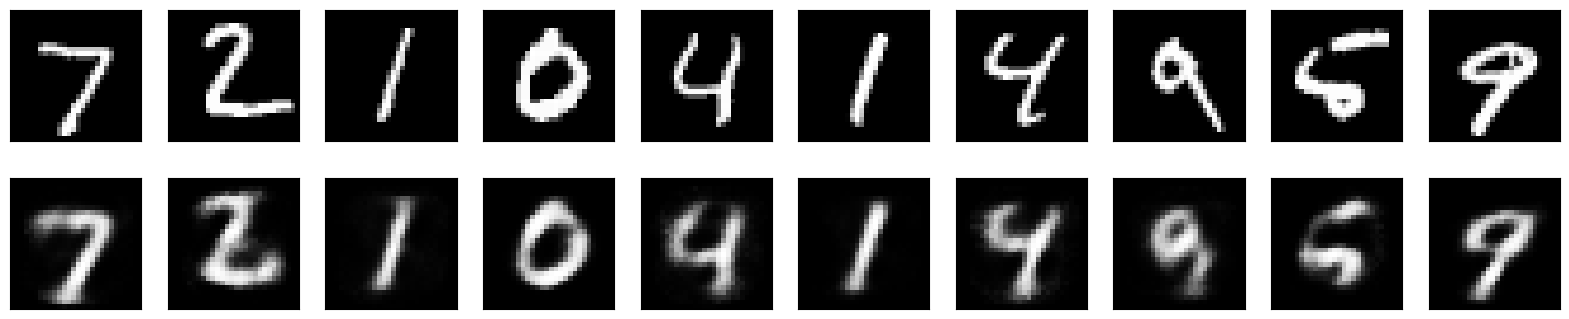

In [60]:
# after 50 epochs the autoencoder seems to reach a stable train/test loss value of about 0.11. 
# We can try to visualize the reconstructed inputs and the encoded representations. We will be using Matplotlib
# encode and decode some digits
# note that we take them from the "test" set

encoded_imgs = encoder.predict(x_test)
decoded_imgs = decoder.predict(encoded_imgs)




# now using Matplotlib to plot the images
n = 10 # how many images we will display
plt.figure(figsize=(20, 4))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
    # display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

plt.show()

<div style="background-color: #ccffcc; padding: 10px;">

# Sparse AutoEncoders
    
    
Adding a sparsity constraint on the encoded representations The representations were only constrained by the size of the hidden layer (32). In such a situation, the hidden layer is learning an approximation of PCA. But another way to constain the representation to be compact is to add a sparsity constraint on the activity of the hiddne representations, so fewer units would "fire" at a given time. We can do this by `adding activity_regularizer` to our Dense layer.

</div>

In [61]:
ENCODING_DIM = 32

input_img = tf.keras.layers.Input(shape=(784,))

# add a dense layer with L1 activity regularizer
encoded = tf.keras.layers.Dense(ENCODING_DIM, activation='relu', 
                                activity_regularizer=tf.keras.regularizers.l1(10e-5))(input_img)
decoded = tf.keras.layers.Dense(784, activation='sigmoid')(encoded)
autoencoder = tf.keras.models.Model(input_img, decoded)
autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')

# let's also create a seprate encoder model
# this mode maps an input to its encoded representation
encoder = tf.keras.models.Model(input_img, encoded)



# as well as decoder model
# create a placeholder for an encoded (32-dimensional) input
encoded_input = tf.keras.layers.Input(shape=(ENCODING_DIM,))

# retrieve the last layer of the autoencoder model
decoder_layer = autoencoder.layers[-1]

# create the decoder model
decoder = tf.keras.models.Model(encoded_input, decoder_layer(encoded_input))

<div style="background-color: #cce5ff; padding: 10px;">
Let's train this for 100 epochs (with added regularization, the model is less likely to overfit and can be trained longer).

you can alter the number of epochs by editing the line `E = 50` to `E = 100`

</div>

In [62]:
E = 100

In [63]:


if train_local:
    # The model ends with a train loss of 0.11 and test loss of 0.10. 
    # The difference is mostly due to the regularization term being added to the loss during training
    autoencoder.fit(x_train, x_train, epochs=E, batch_size=256, shuffle=True,
                validation_data=(x_test, x_test),
                callbacks=[tf.keras.callbacks.LearningRateScheduler(lambda epoch: 1e-1 * 10 ** (epoch / E )),
                                                                    printlr])
   
    # Trained                 
    trained = True
else:
    print('Train_local set to False loading pretrained')
    try:
         autoencoder.load_weights('Model_weights/AE_sparse.ckpt')
    except FileNotFoundError:
         print('grabing pretrained data')

if train_local:
    if trained:
        autoencoder.save_weights('Model_weights/AE_sparse.ckpt')


        print('save trained')

Train_local set to False loading pretrained


313/313 [==============================] - 0s 1ms/step


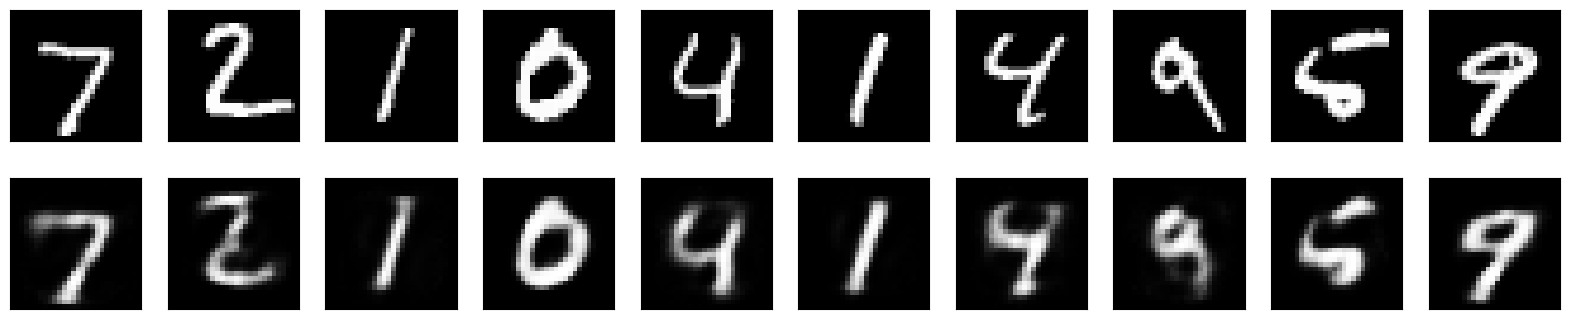

In [64]:

decoded_imgs = autoencoder.predict(x_test)
# now using Matplotlib to plot the images
n = 10 # how many images we will display
plt.figure(figsize=(20, 4))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
    # display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

plt.show()



<div style="background-color: #ccffcc; padding: 10px;">
    The images look pretty similar to the previous model, the only significant difference being the sparsity of the encoded representations. For 100 Epochs encoded_imgs.mean() yields a value of 3.33 over 10,000 test images. whereas with previous model the same quantity was 7.30. So our new model yields encoded representations that are twice sparser.
</div>


<div style="background-color: #e6ccff; padding: 10px;">
    
# Deep autoencoders
    
We do not have to limit ourselves to a single layer as encoder or decoder, we could instead use a stack of layers, making our network more complex
    
Now we're going to decreae the dimensions down the layers for the encoder and increase the dimensions back up to the original dimension for the decoder. Other than adding in extra layers the model is built the same way (same optimizer, loss function etc)
    
Again Epochs is set with `E=50` and we can alter that if you wish
    
</div>    

In [65]:
input_img = tf.keras.layers.Input(shape=(784,))
encoded = tf.keras.layers.Dense(128, activation='relu')(input_img)
encoded = tf.keras.layers.Dense(64, activation='relu')(encoded)
encoded = tf.keras.layers.Dense(32, activation='relu')(encoded)

decoded = tf.keras.layers.Dense(64, activation='relu')(encoded)
decoded = tf.keras.layers.Dense(128, activation='relu')(decoded)
decoded = tf.keras.layers.Dense(784, activation='sigmoid')(decoded)

In [66]:
E = 50

In [67]:
# let's try this
autoencoder = tf.keras.models.Model(input_img, decoded)
autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')

In [68]:
if train_local:
    autoencoder.fit(x_train, x_train, epochs=E, batch_size=256, 
                shuffle=True, validation_data=(x_test, x_test),
                callbacks=[ tf.keras.callbacks.LearningRateScheduler( lambda epoch: 1e-1 * 10 ** (epoch / E )),
                           printlr])
    # Trained                 
    trained = True
else:
    print('Train_local set to False loading pretrained')
    try:
        autoencoder.load_weights('Model_weights/AE_deep.ckpt')
    except FileNotFoundError:
         print('grabing pretrained data')

if train_local:
    if trained:
        autoencoder.save_weights('AE_deep.ckpt')
        print('save trained')



Train_local set to False loading pretrained


313/313 [==============================] - 1s 1ms/step


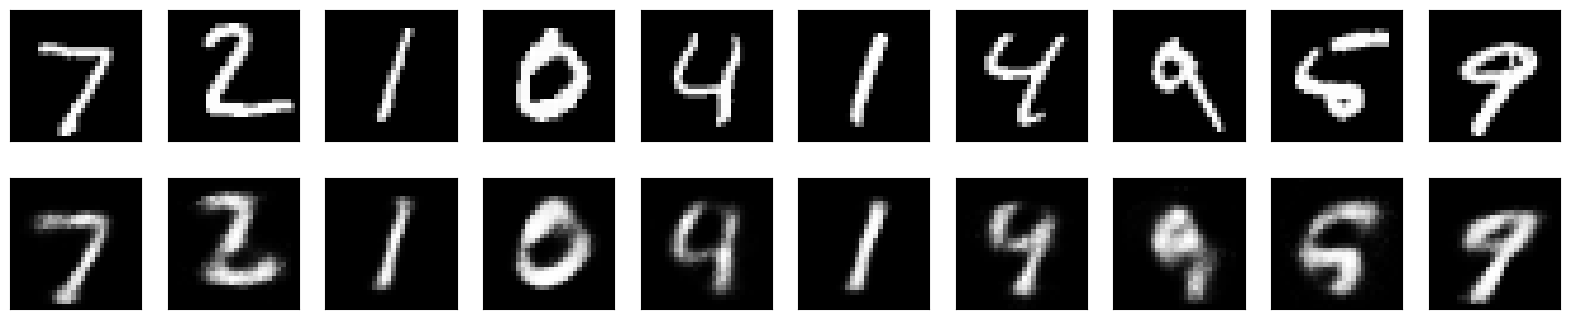

In [69]:
encoded_imgs = encoder.predict(x_test)
decoded_imgs = autoencoder.predict(x_test)
# now using Matplotlib to plot the images
n = 10 # how many images we will display
plt.figure(figsize=(20, 4))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
    # display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

plt.show()

<hr>

# Convolutional autoencoder


<hr>
<div style="background-color: #ccffcc; padding: 10px;">



Since our inputs are images, it makes sense to use convolutional neural networks (CNNs) as encoders and decoders. In practical settings, autoencoders for images are always convolutional since they perform much better.

This encoder will consist in a stack of `Conv2D` and `MaxPooling2D` layers (for spatial down-sampling), while the decoder will consist in a stack of `Conv2D` and `UpSampling2D` layers.

</div>    
 


In [70]:
input_img = tf.keras.layers.Input(shape=(28, 28, 1)) # adapt this if using `channels_first` image data format

x = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', padding='same')(input_img)
x = tf.keras.layers.MaxPooling2D((2, 2), padding='same')(x)
x = tf.keras.layers.Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = tf.keras.layers.MaxPooling2D((2, 2), padding='same')(x)
x = tf.keras.layers.Conv2D(8, (3, 3), activation='relu', padding='same')(x)
encoded = tf.keras.layers.MaxPooling2D((2, 2), padding='same')(x)

# at this point the representation is (4, 4, 8) i.e. 128-dimensional

x = tf.keras.layers.Conv2D(8, (3, 3), activation='relu', padding='same')(encoded)
x = tf.keras.layers.UpSampling2D((2, 2))(x)
x = tf.keras.layers.Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = tf.keras.layers.UpSampling2D((2, 2))(x)
x = tf.keras.layers.Conv2D(16, (3, 3), activation='relu')(x)
x = tf.keras.layers.UpSampling2D((2, 2))(x)
decoded = tf.keras.layers.Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

autoencoder = tf.keras.models.Model(input_img, decoded)
autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')



In [71]:
# to train this model we will with original MNIST digits with shape (samples, 3, 28, 28) 
# and we will just normalize pixel values between 0 and 1
(x_train, _), (x_test, _) = load_data('data_folder/mnist.npz')

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = np.reshape(x_train, (len(x_train), 28, 28, 1))
x_test = np.reshape(x_test, (len(x_test), 28, 28, 1))



<div style="background-color: #cce5ff; padding: 10px;">

This will take a while so we'll use `TensorBoard` callback, this will allow the visulatiation of the training by visiting [http://0.0.0.0:6006](http://0.0.0.0:6006)  
    
Again you can alter the Epochs    
    
</div>    

In [72]:
E = 50

In [73]:
mkdir -p tmp/autoencoder

In [74]:
if train_local:
    autoencoder.fit(x_train, x_train, epochs=E, batch_size=128, shuffle=True, validation_data=(x_test, x_test),
                callbacks=[tf.keras.callbacks.TensorBoard(log_dir='./tmp/autoencoder'),
                           tf.keras.callbacks.LearningRateScheduler( lambda epoch: 1e-1 * 10 ** (epoch / E )),
                           printlr])
    # Trained                 
    trained = True
else:
    print('Train_local set to False loading pretrained')
    try:
        autoencoder.load_weights('Model_weights/AE_conv.ckpt')
    except FileNotFoundError:
         print('grabing pretrained data')

if train_local:
    if trained:
        autoencoder.save_weights('Model_weights/AE_conv.ckpt')
      

        print('save trained')



Train_local set to False loading pretrained



 
 
<div style="background-color: #ccffcc; padding: 10px;">    

For 50 Epochs the model converges to a loss of 0.098, significantly better than previous model which is in large part due to the higher entropic capacity of the encoded representations (128 vs 32 previously).


</div>    

<hr>

313/313 [==============================] - 1s 3ms/step


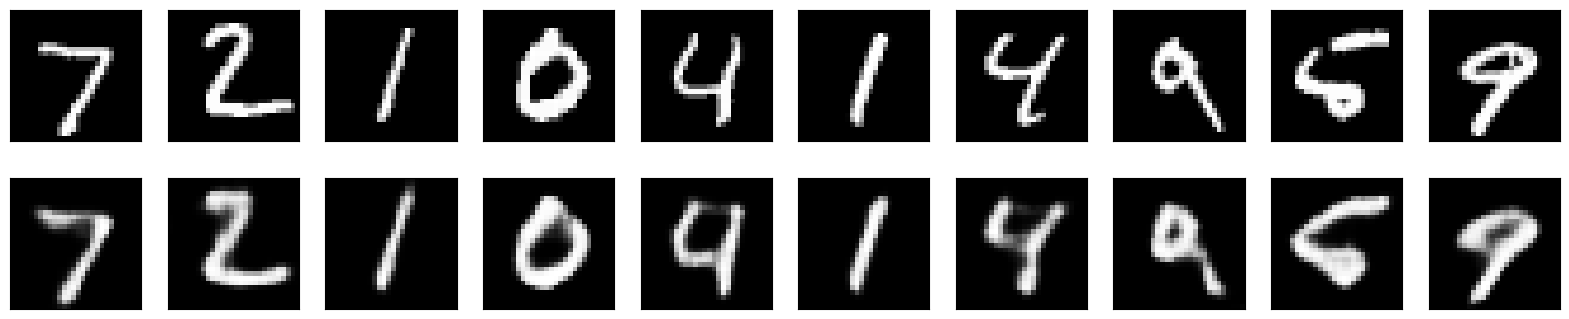

In [77]:
decoded_imgs = autoencoder.predict(x_test)

n = 10
plt.figure(figsize=(20, 4))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

<hr>

# Denoising 

<hr>
<div style="background-color: #ccffcc; padding: 10px;">  

# Application to image denoising

Let's put our convolutional autoencoder to work on an image denoising problem. We will train the autoencoder to map noisy digits images to clean digit images. We will generate synthetic noisy digits by applying a gaussian noise matrix and clip the images between 0 and 1.

</div>

In [78]:
(x_train, _), (x_test, _) = load_data('data_folder/mnist.npz')

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = np.reshape(x_train, (len(x_train), 28, 28, 1))
x_test = np.reshape(x_test, (len(x_test), 28, 28, 1))

<div style="background-color: #cce5ff; padding: 10px;">

Adding in synthetic noise, the plots below show the digits now hidden by noise    
    
</div>

In [79]:
noise_factor = 0.5
x_train_noisy = x_train + noise_factor + np.random.normal(loc=0.0, scale=1.0, size=x_train.shape)
x_test_noisy = x_test + noise_factor + np.random.normal(loc=0.0, scale=1.0, size=x_test.shape)

x_train_noisy = np.clip(x_train_noisy, 0., 1.)
x_test_noisy = np.clip(x_test_noisy, 0., 1.)

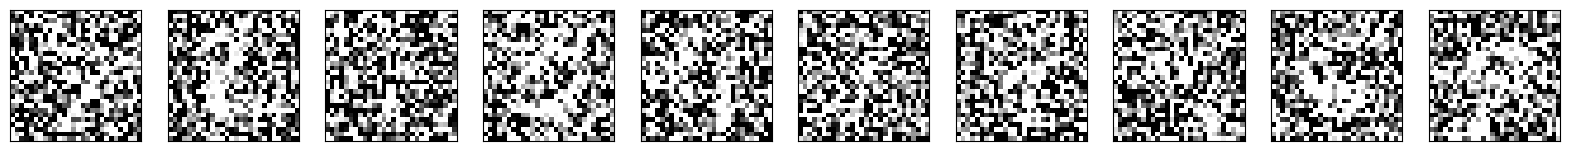

In [80]:
# here's what the noisy digits look like
n = 10
plt.figure(figsize=(20, 2))
for i in range(n):
    ax = plt.subplot(1, n, i + 1)
    plt.imshow(x_test_noisy[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

<div style="background-color: #e6ccff; padding: 10px;">
    

    
Can our autoencoder learn to recover the original digits?

We will use a slightly different model with more filters per layer
    

</div>   


In [81]:

input_img = tf.keras.layers.Input(shape=(28, 28, 1))

x = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
x = tf.keras.layers.MaxPooling2D((2, 2), padding='same')(x)
x = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same')(x)
encoded = tf.keras.layers.MaxPooling2D((2, 2), padding='same')(x)

# the representation is (7, 7, 32)

x = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same')(encoded)
x = tf.keras.layers.UpSampling2D((2, 2))(x)
x = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = tf.keras.layers.UpSampling2D((2, 2))(x)
decoded = tf.keras.layers.Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

autoencoder = tf.keras.models.Model(input_img, decoded)
autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')

<div style="background-color: #cce5ff; padding: 10px;">

We'll train for 100 Epochs but you can return here and play around with different numbers of epochs
    
</div>

In [82]:
E = 100

In [83]:
if train_local:
    # let's train for N epochs
    autoencoder.fit(x_train_noisy, x_train, epochs=E, batch_size=128, shuffle=True, 
                validation_data=(x_test_noisy, x_test), 
                callbacks=[tf.keras.callbacks.TensorBoard(log_dir='./tmp/autoencoder', histogram_freq=0,
                                                          write_graph=False),
                           tf.keras.callbacks.LearningRateScheduler( lambda epoch: 1e-2 * 10 ** (epoch / E )),
                           printlr])
    # Trained                 
    trained = True
else:
    print('Train_local set to False loading pretrained')
    try:
        autoencoder.load_weights('Model_weights/AE_noisy.ckpt')
    except FileNotFoundError:
         print('grabing pretrained data')

if train_local:
    if trained:
        autoencoder.save_weights('Model_weights/AE_noisy.ckpt')
       

        print('save trained')






Train_local set to False loading pretrained


313/313 [==============================] - 1s 3ms/step


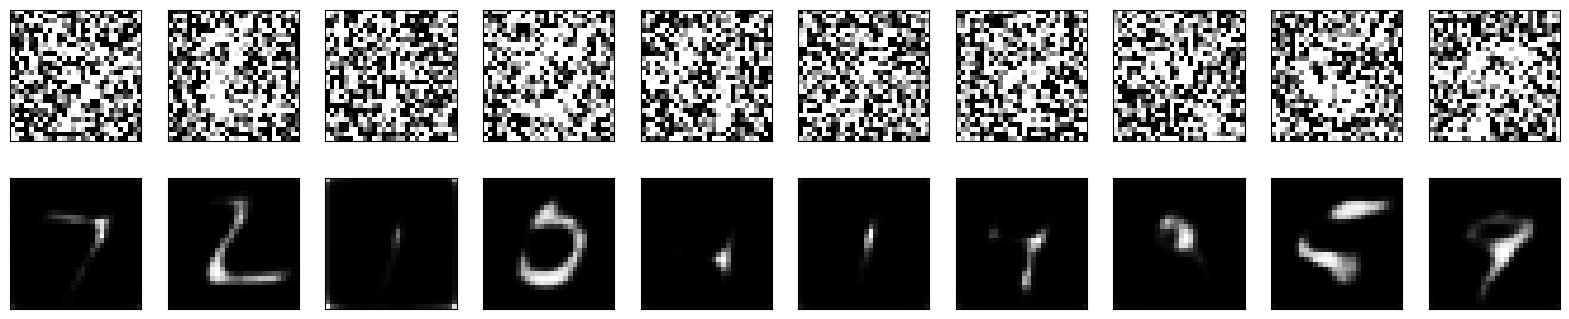

In [84]:
# Let's see how it did
decoded_imgs = autoencoder.predict(x_test)

n = 10
plt.figure(figsize=(20, 4))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test_noisy[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()


<hr>


# Earth Science Examples

<hr>

<hr>


<div style="background-color: #e6ccff; padding: 10px;">
    
<h1> Data Infilling </h1>
 
Here's an example from [Barth et al. 2020] where an autoencoder is used to reconstruct missing SST data.


* SST observations from satellites can be obscured by cloud
* An autoencoder was used to reconstruct the missing data based on the available cloud-free pixels in satellite images


![SST fig Barth 2020](data_folder/figures/SST_Barth_clipped4.png)
    
Fig (a) shows satellite SST, (b) is with added cloud to allow for validation, c) The Autoencoder estimation of sea surface temperature, f) Estimation of SST using more traditional empirical orthogonal methods
    
* Neural networks can learn nonlinear, stochastic features measured at sea surface by satellite sensors. and their use might prove efficient in retraining small-scale structures that more traditional methods may remove / smooth out.    
    
</div>

<div style="background-color: #cce5ff; padding: 10px;">

If you wish to look into this further, the original python code can be found on GitHub although the Authors have superceeded this with a Julia version:
    
* Code: [Git Hub Repo (Archived)](https://github.com/gher-uliege/DINCAE)
* Julia Code: [GitHub Repo](https://github.com/gher-uliege/DINCAE.jl)
* [Example Jupyter Notebook in Julia](https://github.com/gher-uliege/DINCAE.jl/blob/main/examples/DINCAE_tutorial.ipynb)
    
    
**Please be aware the dataset used is very large 100GB+**
    
</div>

<hr>

# Variational AutoEncoders

<hr>
<div style="background-color: #e6ccff; padding: 10px;">
    

Variational autoencoder is where the decoder network can be used independently of the encoder to generate new states similar to the original inputs, by constraining the latent space to be both continuous and complete. Allowing  any point to be sampled and decoded back into something meaningful. This can be done for example in the form of a distribution: A normal distribution is parameterized by a mean (𝜇) and a variance (𝜎) and which is exactly (with some “variations”) what’s done in the case of a VAE.
    
![VAE](data_folder/figures/VAE.png)    
[https://towardsdatascience.com/reparameterization-trick-126062cfd3c3](https://towardsdatascience.com/reparameterization-trick-126062cfd3c3)
    
An Earth Science application could be for ensemble based predictions and weather predictions or climate projections. As long as your distribution is representative of the possible space of inputs and it's potentially a much less computationally expensive way of generating a very large ensemble.

It could be used as just a way of generating synthetic data and more generally, so a lot of us work with extreme data and often the issue with that for machine learning is there are not enough examples of extreme data points. So if you could use an autoencoder to just generate more examples of plausible extreme realizations and that could allow for doing further machine learning training with that kind of data.   
    
<h1> VAE example GCM emulator </h1>
  
Some work by Philip Brohan at the Met Office is detailed on Phillip Brohans website [https://brohan.org/ML_GCM/models/autoencoder/index.html](https://brohan.org/ML_GCM/models/autoencoder/index.html)  

![VAE_Broahn](data_folder/figures/VAE_brohan.png)         
    
* Uses a VAE to emulate a General Circulation Model (GCM)
* Trained on 2568T, T+6h pairs of weather states from reanalysis data
* Used 4 surface variables: Temperature, Mean Sea Level Pressure, U wind, V wind at 2 degree resolution
* Took 35 mins to train and runs 100,000 times faster than a conventional GCM
* Provides plausible representations of the weather but with less variance.
* Could be a great way of quickly estimating general trends    

This is visualized on the site as a video of the estimated states with the latent space displayed in the corner.


![Broahn](data_folder/figures/BrohanGCM.png)     
 

The whole method along with the code can be found [here](https://brohan.org/ML_GCM/index.html)     
    
</div>

# Variational Autoencoders

<div style="background-color: #e6ccff; padding: 10px;">



An encoder network turns the input samples x into two parameters in a latent space, which we will note as z_mean and z_log_sigma. Then we randomly sample similar points z from the latent normal distribution that is assumed to generate the data, via z = z_mean + exp(x_log_sigma) * epsilon, where epsilon is a random normal tensor. Finally, a deocded network maps these latent space points back to the original input data.

The parameters of the model are trained via two loss functions: a reconstriction loss forcing the decoded samples to match the initial inputs (just like in our previous autoencoders), and the KL divergence between the learned latent distribution and the prior distribution, acting as a regulaization term. You could actually get rid of this latter term entirely, although it does help in learning well-formed latent spaces and reducing overfitting to the training data.

    
</div>

In [85]:
 # helper functions
    
def plot_results(models, data, batch_size=128, model_name="vae_mnist"):
    """Plots labels and MNIST digits as function of 2-dim latent vector
    # Arguments:
        models (tuple): encoder and decoder models
        data (tuple): test data and label
        batch_size (int): prediction batch size
        model_name (string): which model is using this function
    """

    encoder, decoder = models
    x_test, y_test = data
    os.makedirs(model_name, exist_ok=True)

    filename = os.path.join(model_name, "vae_mean.png")
    # display a 2D plot of the digit classes in the latent space
    z_mean, _, _ = encoder.predict(x_test,
                                   batch_size=batch_size)
    plt.figure(figsize=(12, 10))
    plt.scatter(z_mean[:, 0], z_mean[:, 1], c=y_test)
    plt.colorbar()
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.savefig(filename)
    plt.show()

    filename = os.path.join(model_name, "digits_over_latent.png")
    # display a 30x30 2D manifold of digits
    n = 30
    digit_size = 28
    figure = np.zeros((digit_size * n, digit_size * n))
    # linearly spaced coordinates corresponding to the 2D plot
    # of digit classes in the latent space
    grid_x = np.linspace(-4, 4, n)
    grid_y = np.linspace(-4, 4, n)[::-1]

    for i, yi in enumerate(grid_y):
        for j, xi in enumerate(grid_x):
            z_sample = np.array([[xi, yi]])
            x_decoded = decoder.predict(z_sample)
            digit = x_decoded[0].reshape(digit_size, digit_size)
            figure[i * digit_size: (i + 1) * digit_size,
                   j * digit_size: (j + 1) * digit_size] = digit

    plt.figure(figsize=(10, 10))
    start_range = digit_size // 2
    end_range = n * digit_size + start_range + 1
    pixel_range = np.arange(start_range, end_range, digit_size)
    sample_range_x = np.round(grid_x, 1)
    sample_range_y = np.round(grid_y, 1)
    plt.xticks(pixel_range, sample_range_x)
    plt.yticks(pixel_range, sample_range_y)
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.imshow(figure, cmap='Greys_r')
    plt.savefig(filename)
    plt.show()

    

<div style="background-color: #ccffcc; padding: 10px;">  
once again we'll load in the data and set up our general model parameters
</div>

In [86]:
(x_train, y_train), (x_test, y_test) = load_data('data_folder/mnist.npz')

image_size = x_train.shape[1]
original_dim = image_size * image_size
x_train = np.reshape(x_train, [-1, original_dim])
x_test = np.reshape(x_test, [-1, original_dim])
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255

In [87]:
# network parameters
input_shape = (original_dim, )
intermediate_dim = 512
batch_size = 128
latent_dim = 2
E = 50


<div style="background-color: #ccffcc; padding: 10px;">  

Here 2 dimensional latent space is made up of the mean and the variance.

</div>

In [88]:
# VAE model = encoder + decoder
# build encoder model
inputs = tf.keras.layers.Input(shape=input_shape, name='encoder_input')
x = tf.keras.layers.Dense(intermediate_dim, activation='relu')(inputs)
z_mean = tf.keras.layers.Dense(latent_dim, name='z_mean')(x)
z_log_var = tf.keras.layers.Dense(latent_dim, name='z_log_var')(x)

<div style="background-color: #ccffcc; padding: 10px;">  
We can use these parameters to sample new similar points from the latent space:
</div>

In [89]:


# reparameterization trick
# instead of sampling from Q(z|X), sample eps = N(0,I)
# z = z_mean + sqrt(var)*eps
def sampling(args):
    z_mean, z_log_var = args
    batch = tf.keras.backend.shape(z_mean)[0]
    dim = tf.keras.backend.int_shape(z_mean)[1]
    # by default, random_normal has mean=0 and std=1.0
    epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
    return z_mean + tf.keras.backend.exp(0.5 * z_log_var) * epsilon
   

In [90]:
# use reparameterization trick to push the sampling out as input
z = tf.keras.layers.Lambda(sampling, output_shape=(latent_dim,), name='z')([z_mean, z_log_var])

# instantiate encoder model
encoder = tf.keras.models.Model(inputs, [z_mean, z_log_var, z], name='encoder')
encoder.summary()
# tf.keras.utils.plot_model(encoder, to_file='vae_mlp_encoder.png', show_shapes=True)

# build decoder model
latent_inputs = tf.keras.layers.Input(shape=(latent_dim,), name='z_sampling')
x = tf.keras.layers.Dense(intermediate_dim, activation='relu')(latent_inputs)
outputs = tf.keras.layers.Dense(original_dim, activation='sigmoid')(x)

# instantiate decoder model
decoder = tf.keras.models.Model(latent_inputs, outputs, name='decoder')
decoder.summary()
# tf.keras.utils.plot_model(decoder, to_file='vae_mlp_decoder.png', show_shapes=True)

# instantiate VAE model
outputs = decoder(encoder(inputs)[2])
vae = tf.keras.models.Model(inputs, outputs, name='vae_mlp')

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 encoder_input (InputLayer)     [(None, 784)]        0           []                               
                                                                                                  
 dense_23 (Dense)               (None, 512)          401920      ['encoder_input[0][0]']          
                                                                                                  
 z_mean (Dense)                 (None, 2)            1026        ['dense_23[0][0]']               
                                                                                                  
 z_log_var (Dense)              (None, 2)            1026        ['dense_23[0][0]']               
                                                                                            

<div style="background-color: #ccffcc; padding: 10px;">  
    
* an end-to-end autoencoder mapping inputs to reconstructions
* an encoder mapping inputs to the latent space
* a generator that can take points on the latent space and will output the corresponding reconstructed samples.

We train the model using the end-to-end model, with a custom loss function: the sum of a reconstruction term, and the KL divergence regularization term.
    
</div>    

In [91]:
models = (encoder, decoder)
data = (x_test, y_test)
# reconstruction_loss = tf.keras.losses.mse(inputs, outputs)
reconstruction_loss = tf.keras.losses.binary_crossentropy(inputs, outputs)

reconstruction_loss *= original_dim

kl_loss = 1 + z_log_var - tf.keras.backend.square(z_mean) - tf.keras.backend.exp(z_log_var)
kl_loss = tf.keras.backend.sum(kl_loss, axis=-1)
kl_loss *= -0.5
vae_loss = tf.keras.backend.mean(reconstruction_loss + kl_loss)
vae.add_loss(vae_loss)
vae.compile(optimizer='adam')
vae.summary()
# tf.keras.utils.plot_model(vae, to_file='vae_mlp.png', show_shapes=True)

Model: "vae_mlp"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 encoder_input (InputLayer)     [(None, 784)]        0           []                               
                                                                                                  
 encoder (Functional)           [(None, 2),          403972      ['encoder_input[0][0]']          
                                 (None, 2),                                                       
                                 (None, 2)]                                                       
                                                                                                  
 decoder (Functional)           (None, 784)          403728      ['encoder[0][2]']                
                                                                                            

In [92]:
if train_local:
    # let's train for N epochs
    vae.fit(x_train, epochs=E, batch_size=batch_size, validation_data=(x_test, None))
    # Trained                 
    trained = True
else:
    print('Train_local set to False loading pretrained')
    try:
        vae.load_weights('Model_weights/vae_mlp.mnist.h5')
    except FileNotFoundError:
         print('grabing pretrained data')

if train_local:
    if trained:
        vae.save_weights('vae_mlp.mnist.h5')


        print('save trained')






Train_local set to False loading pretrained


<hr>

# Visualizing latent space

79/79 [==============================] - 0s 2ms/step


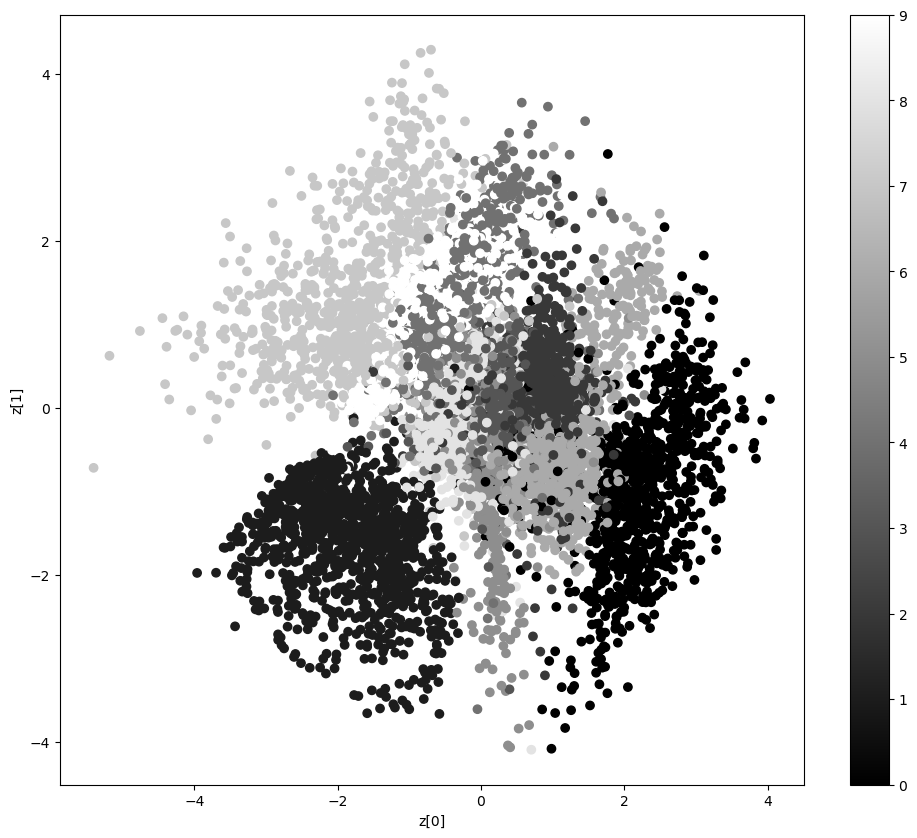

1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 25ms/step


1/1 [==============================] - 0s 16ms/step


ValueError: The number of FixedLocator locations (31), usually from a call to set_ticks, does not match the number of labels (30).

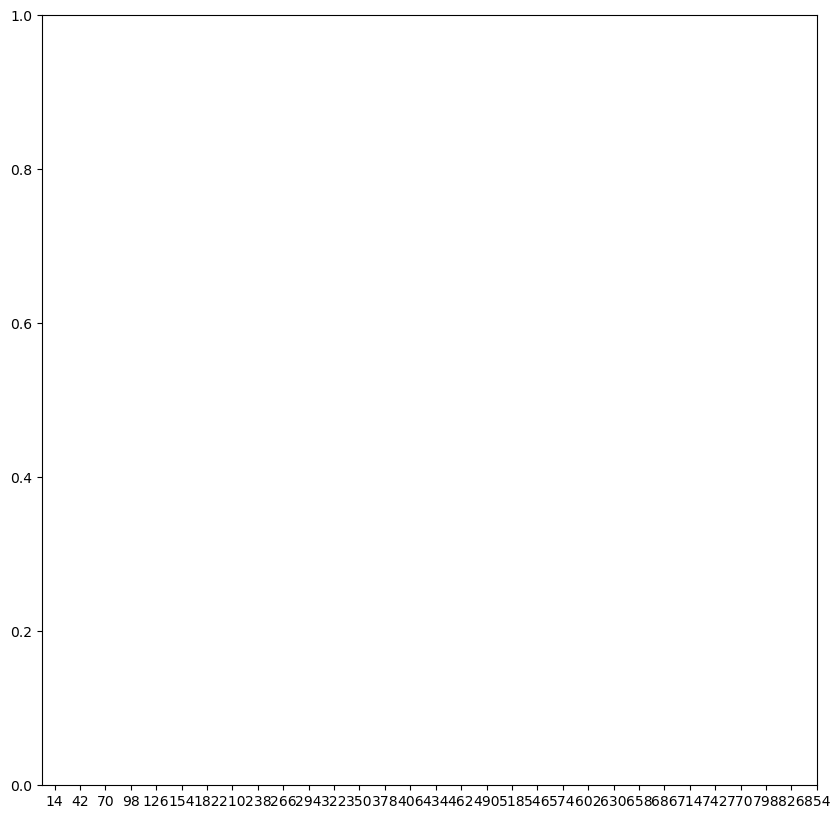

In [93]:


# Because the VAE is a generative model, we can also use it to generate new digits! 
#Here we will scan the latent plane, sampling latent points at regular intervals and 
# generating the corresponding digit for each of these points. 
# This gives us a visualization of the latent manifold that "generates" the MNIST digits.
plot_results(models, data, batch_size=batch_size, model_name='vae_mlp')



<hr>
<div style="background-color: #ccffcc; padding: 10px;">  

Finally above is an example of how you can kind of plot the latent space. These are just the the two dimensions of the latent space and all these points where the input date has mapped to, coloured based on what the original digit was. 
    
So the lower numbers at the blue end, to higher numbers at the red end. You can clearly see here the clustering so that each of the the digits in certain areas of of the latent space. Something in this latent representation is capturing kind of common features for specific Number classifications so that will then be useful when it's decoded back up for the the network to predict generally.
</div>